In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
import soundfile as sf
from scipy.io import wavfile

In [2]:
def read_wav_file(file_path):
    """
    Đọc tệp WAV và trả về dữ liệu âm thanh (y) và tốc độ lấy mẫu (fs).
    """
    y, fs = librosa.load(file_path)
    return y, fs

In [3]:
def calculate_ste(y, frame_size=256, hop_size=128):
    """
    Tính toán năng lượng theo thời gian ngắn (STE) của tín hiệu âm thanh.

    Parameters:
        y (numpy.ndarray): Tín hiệu âm thanh.
        frame_size (int): Kích thước của khung.
        hop_size (int): Kích thước của bước nhảy.

    Returns:
        numpy.ndarray: Mảng STE.
    """
    num_frames = len(y) - frame_size + hop_size
    num_frames = num_frames // hop_size
    ste = np.zeros(num_frames)
    
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        ste[i] = np.sum(np.abs(y[start:end]) ** 2)
    
    return ste

In [4]:
def normalize(ste):
    """
    Chuẩn hóa năng lượng theo thời gian ngắn (STE).

    Parameters:
        ste (numpy.ndarray): Mảng STE.

    Returns:
        numpy.ndarray: Mảng STE đã được chuẩn hóa.
    """
    return ste / np.max(ste)

In [5]:
def find_voiced_segments(ste, threshold):
    """
    Tìm các phân đoạn nói dựa trên giá trị STE và ngưỡng tốt nhất.
    """
    starts = []
    ends = []
    start = None
    end = None

    for i in range(len(ste)):
        if ste[i] > threshold:
            if end is None:
                start = i
            end = i + 1
        else:
            if start is not None:
                starts.append(start)
                ends.append(end)
                start = None
                end = None

    return starts, ends

In [6]:
def remove_short_silences(starts, ends, hop_size, fs, min_duration):
    new_starts = []
    new_ends = []
    for start, end in zip(starts, ends):
        duration = (end - start) * hop_size / fs
        if duration >= min_duration:
            new_starts.append(start)
            new_ends.append(end)
    return new_starts, new_ends

In [7]:
def process_ste(y, fs, frame_size, hop_size, best_threshold):
    """
    Xử lý Short-term energy (STE) và loại bỏ các khoảng im lặng ngắn.
    """
    # Tính toán STE
    ste = calculate_ste(y, frame_size, hop_size)
    ste = normalize(ste)
    
    # Tìm các đoạn có giọng nói
    starts, ends = find_voiced_segments(ste, best_threshold)
    
    # Loại bỏ các khoảng im lặng ngắn
    starts, ends = remove_short_silences(starts, ends, hop_size, fs, 0.3)
    # Vẽ biểu đồ STE theo thời gian
    plt.figure(figsize=(10, 4))
    times = np.arange(len(ste)) * hop_size / fs
    plt.plot(times, ste, label='Năng lượng ngắn hạn')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Năng lượng')
    plt.title('Năng lượng ngắn hạn (STE) theo thời gian')
    plt.grid(True)
    plt.legend()
    plt.show()

    return ste, starts, ends

In [8]:
def process_audio_file(file_path, frame_size=256, hop_size=128, best_threshold=0.0002, min_segment_duration=1.0):
    # Load the audio file
    y, fs = librosa.load(file_path)

    # Calculate STE and remove short silent segments
    ste, starts, ends = process_ste(y, fs, frame_size, hop_size, best_threshold)

    audio_segments = []

    print(y, fs)

    for i in range(len(starts)):
        segment_duration = ends[i] - starts[i]
        duration = (ends[i] - starts[i]) * hop_size / fs
        if duration >= min_segment_duration and duration <= 10.0:
            audio_segment = y[int(starts[i] * hop_size):int(ends[i] * hop_size)]
            
            # Save the audio segment as a WAV file
            output_file = f"D:/data_analysis/speech_emotion_recognition/audio_test/Bong_Dung_Muon_Khoc/divide_segment/1/segment_{i}_3.wav"
            sf.write(output_file, audio_segment, fs)

            audio_segments.append(audio_segment)

    return audio_segments

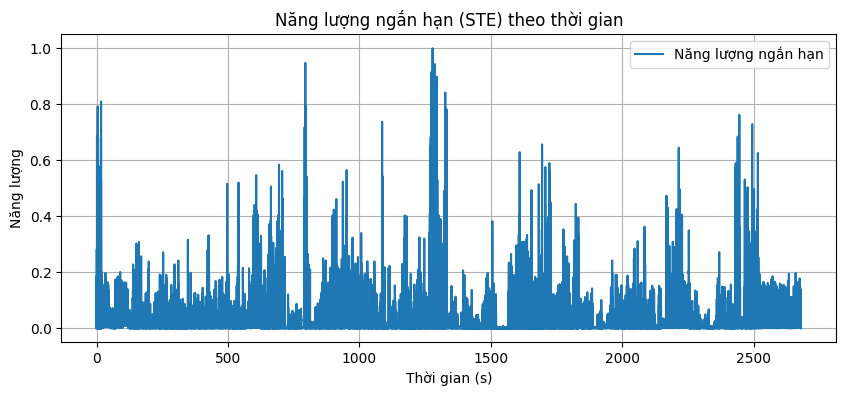

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.5474735e-13
 -4.5474735e-13 -1.1368684e-12] 22050


[array([0.01311239, 0.01711294, 0.01827612, ..., 0.01880155, 0.01896302,
        0.0156935 ], dtype=float32),
 array([0.020642  , 0.01815638, 0.01644662, ..., 0.00180121, 0.00261198,
        0.00700912], dtype=float32),
 array([-0.01437646, -0.01082392, -0.01509286, ...,  0.05331187,
        -0.00636922,  0.00093374], dtype=float32),
 array([0.00114797, 0.00236487, 0.00279144, ..., 0.02404984, 0.02192143,
        0.01483181], dtype=float32),
 array([ 0.00793709,  0.00326537,  0.00165336, ..., -0.01989478,
        -0.02578992, -0.02480379], dtype=float32),
 array([ 0.00081168,  0.00519211, -0.00067642, ..., -0.00780704,
        -0.00548549, -0.00272362], dtype=float32),
 array([ 0.00314749,  0.00407531,  0.00545726, ..., -0.00645507,
         0.00013911,  0.00522726], dtype=float32),
 array([ 0.00393786,  0.00528482,  0.01292691, ..., -0.0115316 ,
        -0.00839414, -0.01200369], dtype=float32),
 array([ 0.00143248,  0.02945255, -0.00104864, ..., -0.02140914,
        -0.0205033 , -0.0

In [9]:
process_audio_file(r"D:\data_analysis\speech_emotion_recognition\audio_test\Bong_Dung_Muon_Khoc\raw\3.wav")